In [121]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

# Classical Risk Estimation

Let $X$ be a real-valued random variable representing losses, and let $\alpha \in (0,1)$ be a tail probability level.<br>
If $X < 0$, this corresponds to a gain (profit).<br>
If $X > 0$, this corresponds to a loss.

In [123]:
n_samples = 1000

def ecdf(samples: np.ndarray):
    """Return x (sorted) and empirical CDF values."""
    x = np.sort(np.asarray(samples).ravel())
    n = x.size
    y = np.arange(1, n + 1) / n
    return x, y

def plot_cdf_comparison(
    sampled,
    perfect_cdf=None,          # callable: F(x) -> CDF
    perfect_x=None,            # optional grid for "perfect" curve
    perfect_cdf_values=None,   # optional precomputed CDF on perfect_x
    xlim=None,
    title="CDF: sampled vs perfect",
    label_sampled="Sampled (empirical CDF)",
    label_perfect="Perfect (analytical CDF)",
):
    # Empirical CDF from samples
    xs, ys = ecdf(sampled)

    # Build x-grid for perfect CDF if not supplied
    if perfect_x is None:
        lo = np.min(xs) if xlim is None else xlim[0]
        hi = np.max(xs) if xlim is None else xlim[1]
        perfect_x = np.linspace(lo, hi, 2000)

    # Perfect CDF values (either callable or precomputed)
    if perfect_cdf_values is None:
        if perfect_cdf is None:
            raise ValueError("Provide either perfect_cdf (callable) or (perfect_x, perfect_cdf_values).")
        perfect_cdf_values = perfect_cdf(perfect_x)

    # Plot
    plt.figure(figsize=(7, 4.5))
    plt.step(xs, ys, where="post", linewidth=2, label=label_sampled)
    plt.plot(perfect_x, perfect_cdf_values, linewidth=2, label=label_perfect)

    if xlim is not None:
        plt.xlim(*xlim)

    plt.ylim(0, 1)
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Loss Models Considered

To see how different risk measures behave under different distribution, we study
three classical distributions for the loss variable $X$.


### Normal distribution: $X \sim \mathcal{N}(\mu,\sigma^2)$<br>


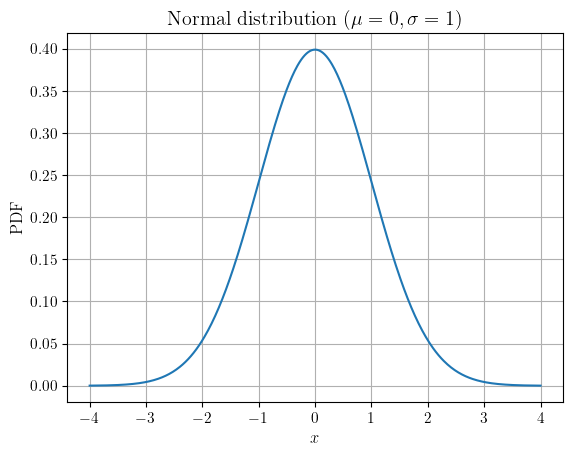

In [124]:
from scipy.stats import norm

normal_mu = 0.0
normal_sigma = 1.0

x = np.linspace(normal_mu - 4*normal_sigma, normal_mu + 4*normal_sigma, 500)
y = norm.pdf(x)

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel(r"PDF")
plt.title(r"Normal distribution ($\mu=0, \sigma=1$)")
plt.grid(True)
plt.show()

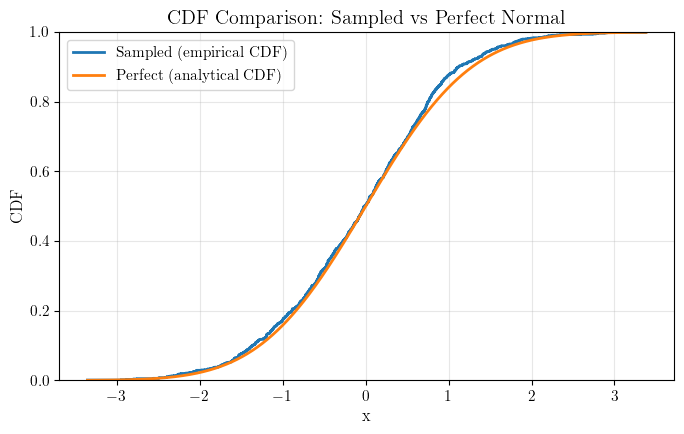

In [125]:
normal_samples = np.random.normal(loc=normal_mu, scale=normal_sigma, size=n_samples)

plot_cdf_comparison(
    sampled=normal_samples,
    perfect_cdf=lambda x: norm.cdf(x, loc=normal_mu, scale=normal_sigma),
    title="CDF Comparison: Sampled vs Perfect Normal"
)

### Lognormal distribution: $\log X \sim \mathcal{N}(\mu,\sigma^2)$ <br>

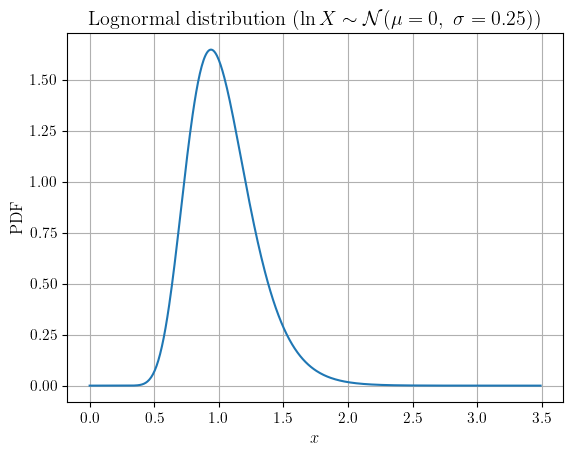

In [126]:
from scipy.stats import lognorm

lognorm_mu = 0
lognorm_sigma = 0.25

x = np.linspace(1e-4, np.exp(lognorm_mu + 5*lognorm_sigma), 500)
y = lognorm.pdf(x, s=lognorm_sigma, scale=np.exp(lognorm_mu))

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel("PDF")
plt.title(r"Lognormal distribution ($\ln X \sim \mathcal{N}(\mu=0,\ \sigma=0.25)$)")
plt.grid(True)
plt.show()


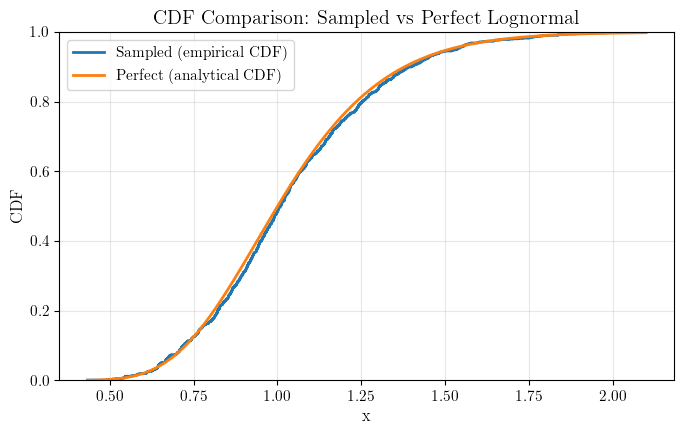

In [127]:
lognormal_samples = np.random.lognormal(mean=lognorm_mu, sigma=lognorm_sigma, size=n_samples)

plot_cdf_comparison(
    sampled=lognormal_samples,
    perfect_cdf=lambda x: lognorm.cdf(
        x,
        s=lognorm_sigma,        # shape parameter
        scale=np.exp(lognorm_mu)
    ),
    title="CDF Comparison: Sampled vs Perfect Lognormal"
)

### Student-t distribution: $X \sim t_\nu(\mu,\sigma)$<br>

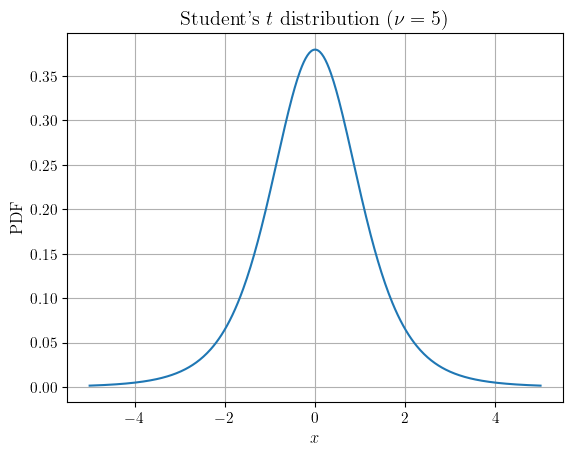

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

student_df = 5
student_loc = 0.0
student_scale = 1.0

x = np.linspace(-5, 5, 500)
y = t.pdf(x, df=student_df, loc=student_loc, scale=student_scale)

plt.figure()
plt.plot(x, y)
plt.xlabel(r"$x$")
plt.ylabel(r"PDF")
plt.title(r"Student's $t$ distribution ($\nu=5$)")
plt.grid(True)
plt.show()


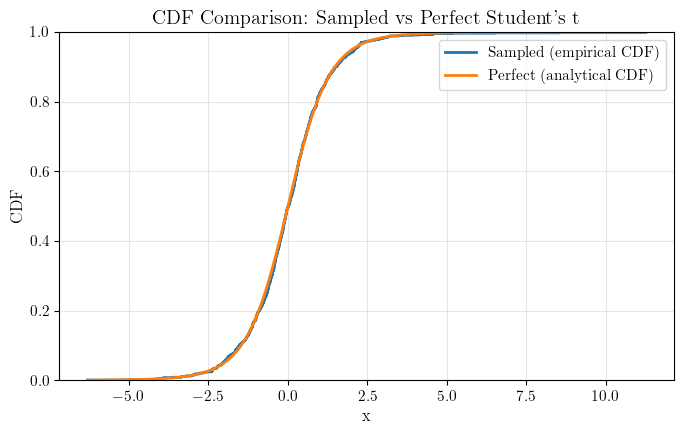

In [129]:
student_samples = student_loc + student_scale * np.random.standard_t(df=student_df, size=n_samples)

plot_cdf_comparison(
    sampled=student_samples,
    perfect_cdf=lambda x: t.cdf(
        (x - student_loc) / student_scale,  # standardize
        df=student_df
    ),
    title="CDF Comparison: Sampled vs Perfect Student's t"
)

## Value at Risk (VaR)

\begin{equation}
\mathrm{VaR}_\alpha(X)
=
\inf \left\{ x \in \mathbb{R} \;\middle|\; \mathbb{P}(X \le x) \ge \alpha \right\}
\end{equation}

In [130]:
alpha = 0.95

In [131]:
# Analytical calculation of the VaR for a normal distribution
normal_var = normal_mu + normal_sigma * norm.ppf(alpha)
print(normal_var)

# Numerical estimation of the VaR using Monte Carlo simulation
normal_mc_var = np.percentile(normal_samples, alpha * 100)
print(normal_mc_var)

1.644853626951472
1.5194611759674836


In [132]:
# Analytical calculation of the VaR for a lognormal distribution
lognormal_var = np.exp(lognorm_mu + lognorm_sigma * norm.ppf(alpha))
print(lognormal_var)

# Numerical estimation of the VaR using Monte Carlo simulation
lognormal_mc_var = np.percentile(lognormal_samples, alpha * 100)
print(lognormal_mc_var)


1.5086472777008935
1.5300844377977902


In [133]:
# Analytical calculation of the VaR for a Student's t distribution
student_var = student_loc + student_scale * t.ppf(alpha, df=student_df)
print(student_var)


# Numerical estimation of the VaR using Monte Carlo simulation
student_mc_var = np.percentile(student_samples, alpha * 100)
print(student_mc_var)

2.015048373333023
2.099259737702408


## Conditional Value at Risk (CVaR)

\begin{equation}
\mathrm{CVaR}_{\alpha}(X)
=
\frac{1}{1 - \alpha}
\int_\alpha^1 \mathrm{VaR}_u(X)\,du
\end{equation}

In [134]:
alpha = 0.95

In [135]:
# Analytical calculation of the CVaR for a normal distribution
normal_cvar = normal_mu + normal_sigma * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
print(normal_cvar)

# Numerical estimation of the CVaR using Monte Carlo simulation
normal_mc_cvar = normal_samples[normal_samples >= normal_mc_var].mean()
print(normal_mc_cvar)

2.0627128075074275
1.9881359006289403


In [136]:
# Analytical calculation of the CVaR for a lognormal distribution
lognormal_cvar = (
    np.exp(lognorm_mu + 0.5 * lognorm_sigma**2)
    * norm.cdf(lognorm_sigma - norm.ppf(alpha))
    / (1 - alpha)
)
print(lognormal_cvar)

# Numerical estimation of the CVaR using Monte Carlo simulation
lognormal_mc_cvar = lognormal_samples[lognormal_samples >= lognormal_mc_var].mean()
print(lognormal_mc_cvar)


1.6823606305486865
1.680206771286182


In [137]:
# Analytical CVaR (only valid if student_df > 1)
z = (student_var - student_loc) / student_scale  # standardized VaR

student_cvar = (
    student_loc
    + student_scale
    * ((student_df + z**2) / (student_df - 1))
    * (t.pdf(z, df=student_df) / (1 - alpha))
)
print(student_cvar)

# Monte Carlo CVaR
student_mc_cvar = student_samples[student_samples >= student_mc_var].mean()
print(student_mc_cvar)

2.8901289462730744
3.1622179446348775


## Range Value at Risk (RVaR)

\begin{equation}
\mathrm{RVaR}_{\alpha_1,\alpha_2}(X)
=
\frac{1}{\alpha_2 - \alpha_1}
\int_{\alpha_1}^{\alpha_2} \mathrm{VaR}_u(X)\,du
\end{equation}

In [138]:
alpha1 = 0.80
alpha2 = 0.90

In [139]:
# Analytical calculation of the RVaR for a normal distribution
normal_rvar = normal_mu + normal_sigma * (norm.pdf(norm.ppf(alpha1)) - norm.pdf(norm.ppf(alpha2))) / (alpha2 - alpha1)
print(normal_rvar)

# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(normal_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
normal_mc_rvar = sorted_samples[i1:i2].mean()
print(normal_mc_rvar)


1.044635884753215
0.9097584890204031


In [140]:
# Analytical calculation of the RVaR for a normal distribution (range [alpha1, alpha2])
lognormal_rvar = (
    np.exp(lognorm_mu + 0.5 * lognorm_sigma**2)
    * (norm.cdf(norm.ppf(alpha2) - lognorm_sigma) - norm.cdf(norm.ppf(alpha1) - lognorm_sigma))
    / (alpha2 - alpha1)
)
print(lognormal_rvar)

# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(lognormal_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
lognorm_mc_rvar = sorted_samples[i1:i2].mean()
print(lognorm_mc_rvar)

1.2990785031680094
1.3169166820793154


In [141]:
from scipy.integrate import quad

# Analytical calculation of the RVaR for a Student's t distribution (range [alpha1, alpha2])
# There is no simple closed-form expression for the RVaR of a Student's t distribution.

def student_var_u(u):
    return student_loc + student_scale * t.ppf(u, df=student_df)

student_rvar = quad(student_var_u, alpha1, alpha2, limit=20)[0] / (alpha2 - alpha1)
print(student_rvar)


# Numerical estimation of the RVaR using Monte Carlo simulation
sorted_samples = np.sort(student_samples)
n = len(sorted_samples)
i1 = max(int(np.ceil(alpha1 * n)),0)
i2 = min(int(np.floor(alpha2 * n)),n)
student_mc_rvar = sorted_samples[i1:i2].mean()
print(student_mc_rvar)

1.1693848193242924
1.1663529129937487


## Numerical Study

In [142]:
n_samples = range(1000, 100001, 1000)
reps = 100
distributions = {
    'normal': {'mu': normal_mu, 'sigma': normal_sigma},
    'lognorm': {'mu': lognorm_mu, 'sigma': lognorm_sigma},
    'student': {'df': student_df, 'loc': student_loc, 'scale': student_scale}
}


def get_analytical_values(dist, params):
    alpha, alpha1, alpha2 = 0.95, 0.80, 0.90
    
    if dist == 'normal':
        mu, sigma = params.get('mu', 0), params.get('sigma', 1)
        # VaR
        var = norm.ppf(alpha, mu, sigma)
        # CVaR (Upper Tail ES)
        cvar = mu + sigma * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
        # RVaR
        z1, z2 = norm.ppf(alpha1), norm.ppf(alpha2)
        rvar = mu + (sigma / (alpha2 - alpha1)) * (norm.pdf(z1) - norm.pdf(z2))
        return var, cvar, rvar

    elif dist == 'lognorm':
        mu, sigma = params.get('mu', 0), params.get('sigma', 1)
        # VaR
        var = lognorm.ppf(alpha, s=sigma, scale=np.exp(mu))
        # CVaR
        mean_log = np.exp(mu + sigma**2 / 2)
        cvar = mean_log * (1 - norm.cdf(norm.ppf(alpha) - sigma)) / (1 - alpha)
        # RVaR
        term1 = norm.cdf(norm.ppf(alpha1) - sigma)
        term2 = norm.cdf(norm.ppf(alpha2) - sigma)
        rvar = (mean_log / (alpha2 - alpha1)) * (term2 - term1)
        return var, cvar, rvar

    elif dist == 'student':
        df, loc, scale = params.get('df', 5), params.get('loc', 0), params.get('scale', 1)
        # VaR
        var = loc + scale * t.ppf(alpha, df)
        # Helper G(x) = - (df + x^2)/(df-1) * p(x)
        def G_t(x, v): return - (v + x**2) / (v - 1) * t.pdf(x, v)
        # CVaR
        cvar = loc + scale * (-G_t(t.ppf(alpha, df), df) / (1 - alpha))
        # RVaR
        t1, t2 = t.ppf(alpha1, df), t.ppf(alpha2, df)
        rvar = loc + scale * ((G_t(t2, df) - G_t(t1, df)) / (alpha2 - alpha1))
        return var, cvar, rvar
    
    return 0, 0, 0


def run_mc_study(dist_name, params, n_samples_list, reps=50):
    results = {'n_samples': [], 'VaR': [], 'CVaR': [], 'RVaR': []}
    
    for n in n_samples_list:
        for _ in range(reps):
            # Generate Samples
            if dist_name == 'normal':
                samples = np.random.normal(params['mu'], params['sigma'], n)
            elif dist_name == 'lognorm':
                samples = np.random.lognormal(params['mu'], params['sigma'], n)
            elif dist_name == 'student':
                samples = params['loc'] + params['scale'] * np.random.standard_t(params['df'], n)
            
            samples = np.sort(samples)
            
            # Calculate Estimators
            # VaR (95%)
            idx_var = int(0.95 * n)
            var_est = samples[min(idx_var, n-1)]
            
            # CVaR (Average > 95%)
            cvar_est = samples[idx_var:].mean()
            
            # RVaR (Average 80% - 90%)
            idx1, idx2 = int(0.80 * n), int(0.90 * n)
            rvar_est = samples[idx1:max(idx2, idx1+1)].mean()
            
            results['n_samples'].append(n)
            results['VaR'].append(var_est)
            results['CVaR'].append(cvar_est)
            results['RVaR'].append(rvar_est)
            
    return pd.DataFrame(results)

def plot_convergence(df_results, analytical_value, measure_name, dist_name, axes=None):
    """
    Plots the Monte Carlo convergence for a specific risk measure.
    
    Parameters:
    -----------
    df_results : pd.DataFrame
        DataFrame containing 'n_samples' and a column named `measure_name` (e.g., 'VaR')
        with the estimate from each repetition.
    analytical_value : float
        The true analytical value of the measure.
    measure_name : str
        Name of the measure (e.g., 'VaR', 'CVaR', 'RVaR').
    dist_name : str
        Name of the distribution (for titling).
    axes : list of matplotlib.axes.Axes, optional
        A list of 2 axes [ax_left, ax_right] to plot on. If None, new figures are created.
    """
    
    # Setup axes
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle(f"{measure_name} Convergence ({dist_name})", fontsize=20)
    
    ax_est, ax_err = axes
    
    # Extract unique sample sizes
    n_samples_list = sorted(df_results['n_samples'].unique())
    
    # --- Plot 1: Estimates vs N ---
    # We plot all repetitions as scatter points
    ax_est.plot(df_results['n_samples'], df_results[measure_name], 
                '+', color='blue', alpha=0.5, markersize=8, label='MC Estimates')
    
    # Plot the analytical true value line
    ax_est.axhline(analytical_value, color='black', linestyle='--', linewidth=2, 
                   label=f'True {measure_name} = {analytical_value:.4f}')
    
    ax_est.set_xlabel(r'$N$ (Number of Samples)', fontsize=14)
    ax_est.set_ylabel(fr'{measure_name}$_{{MC}}$', fontsize=14)
    ax_est.set_title(f'{measure_name} Estimates', fontsize=16)
    ax_est.grid(True, alpha=0.3)
    ax_est.legend(fontsize=12, loc='best')
    ax_est.set_xlim(min(n_samples_list)*0.9, max(n_samples_list)*1.1)

    # --- Plot 2: Max Relative Error vs N (Log-Log) ---
    max_errors = []
    for n in n_samples_list:
        # Filter data for this specific N
        subset = df_results[df_results['n_samples'] == n][measure_name]
        
        # Calculate Max Relative Error: max(|Estimate - True| / |True|)
        # Handle division by zero if true value is 0
        denom = abs(analytical_value) if abs(analytical_value) > 1e-9 else 1.0
        error = np.max(np.abs(subset - analytical_value) / denom)
        max_errors.append(error)
    
    # Plot the errors
    ax_err.loglog(n_samples_list, max_errors, 'k+', markersize=10, markeredgewidth=2, label='Max Relative Error')
    
    # Add 1/sqrt(N) reference line (Slope = -0.5)
    # Trick: Anchor the line to the first error point to make it visually comparable
    if max_errors and max_errors[0] > 0:
        # C / sqrt(N_0) = Error_0  =>  C = Error_0 * sqrt(N_0)
        C = max_errors[0] * np.sqrt(n_samples_list[0])
        upper_bound = [C / np.sqrt(n) for n in n_samples_list]
        ax_err.loglog(n_samples_list, upper_bound, 'r--', linewidth=2, label=r'$O(1/\sqrt{N})$')

    ax_err.set_xlabel(r'$N$', fontsize=14)
    ax_err.set_ylabel(r'Max Relative Error $\epsilon_{MC}$', fontsize=14)
    ax_err.set_title(f'{measure_name} Error Convergence', fontsize=16)
    ax_err.grid(True, which="both", linestyle='--', alpha=0.5)
    ax_err.legend(fontsize=12)
    ax_err.set_xlim(min(n_samples_list)*0.9, max(n_samples_list)*1.1)

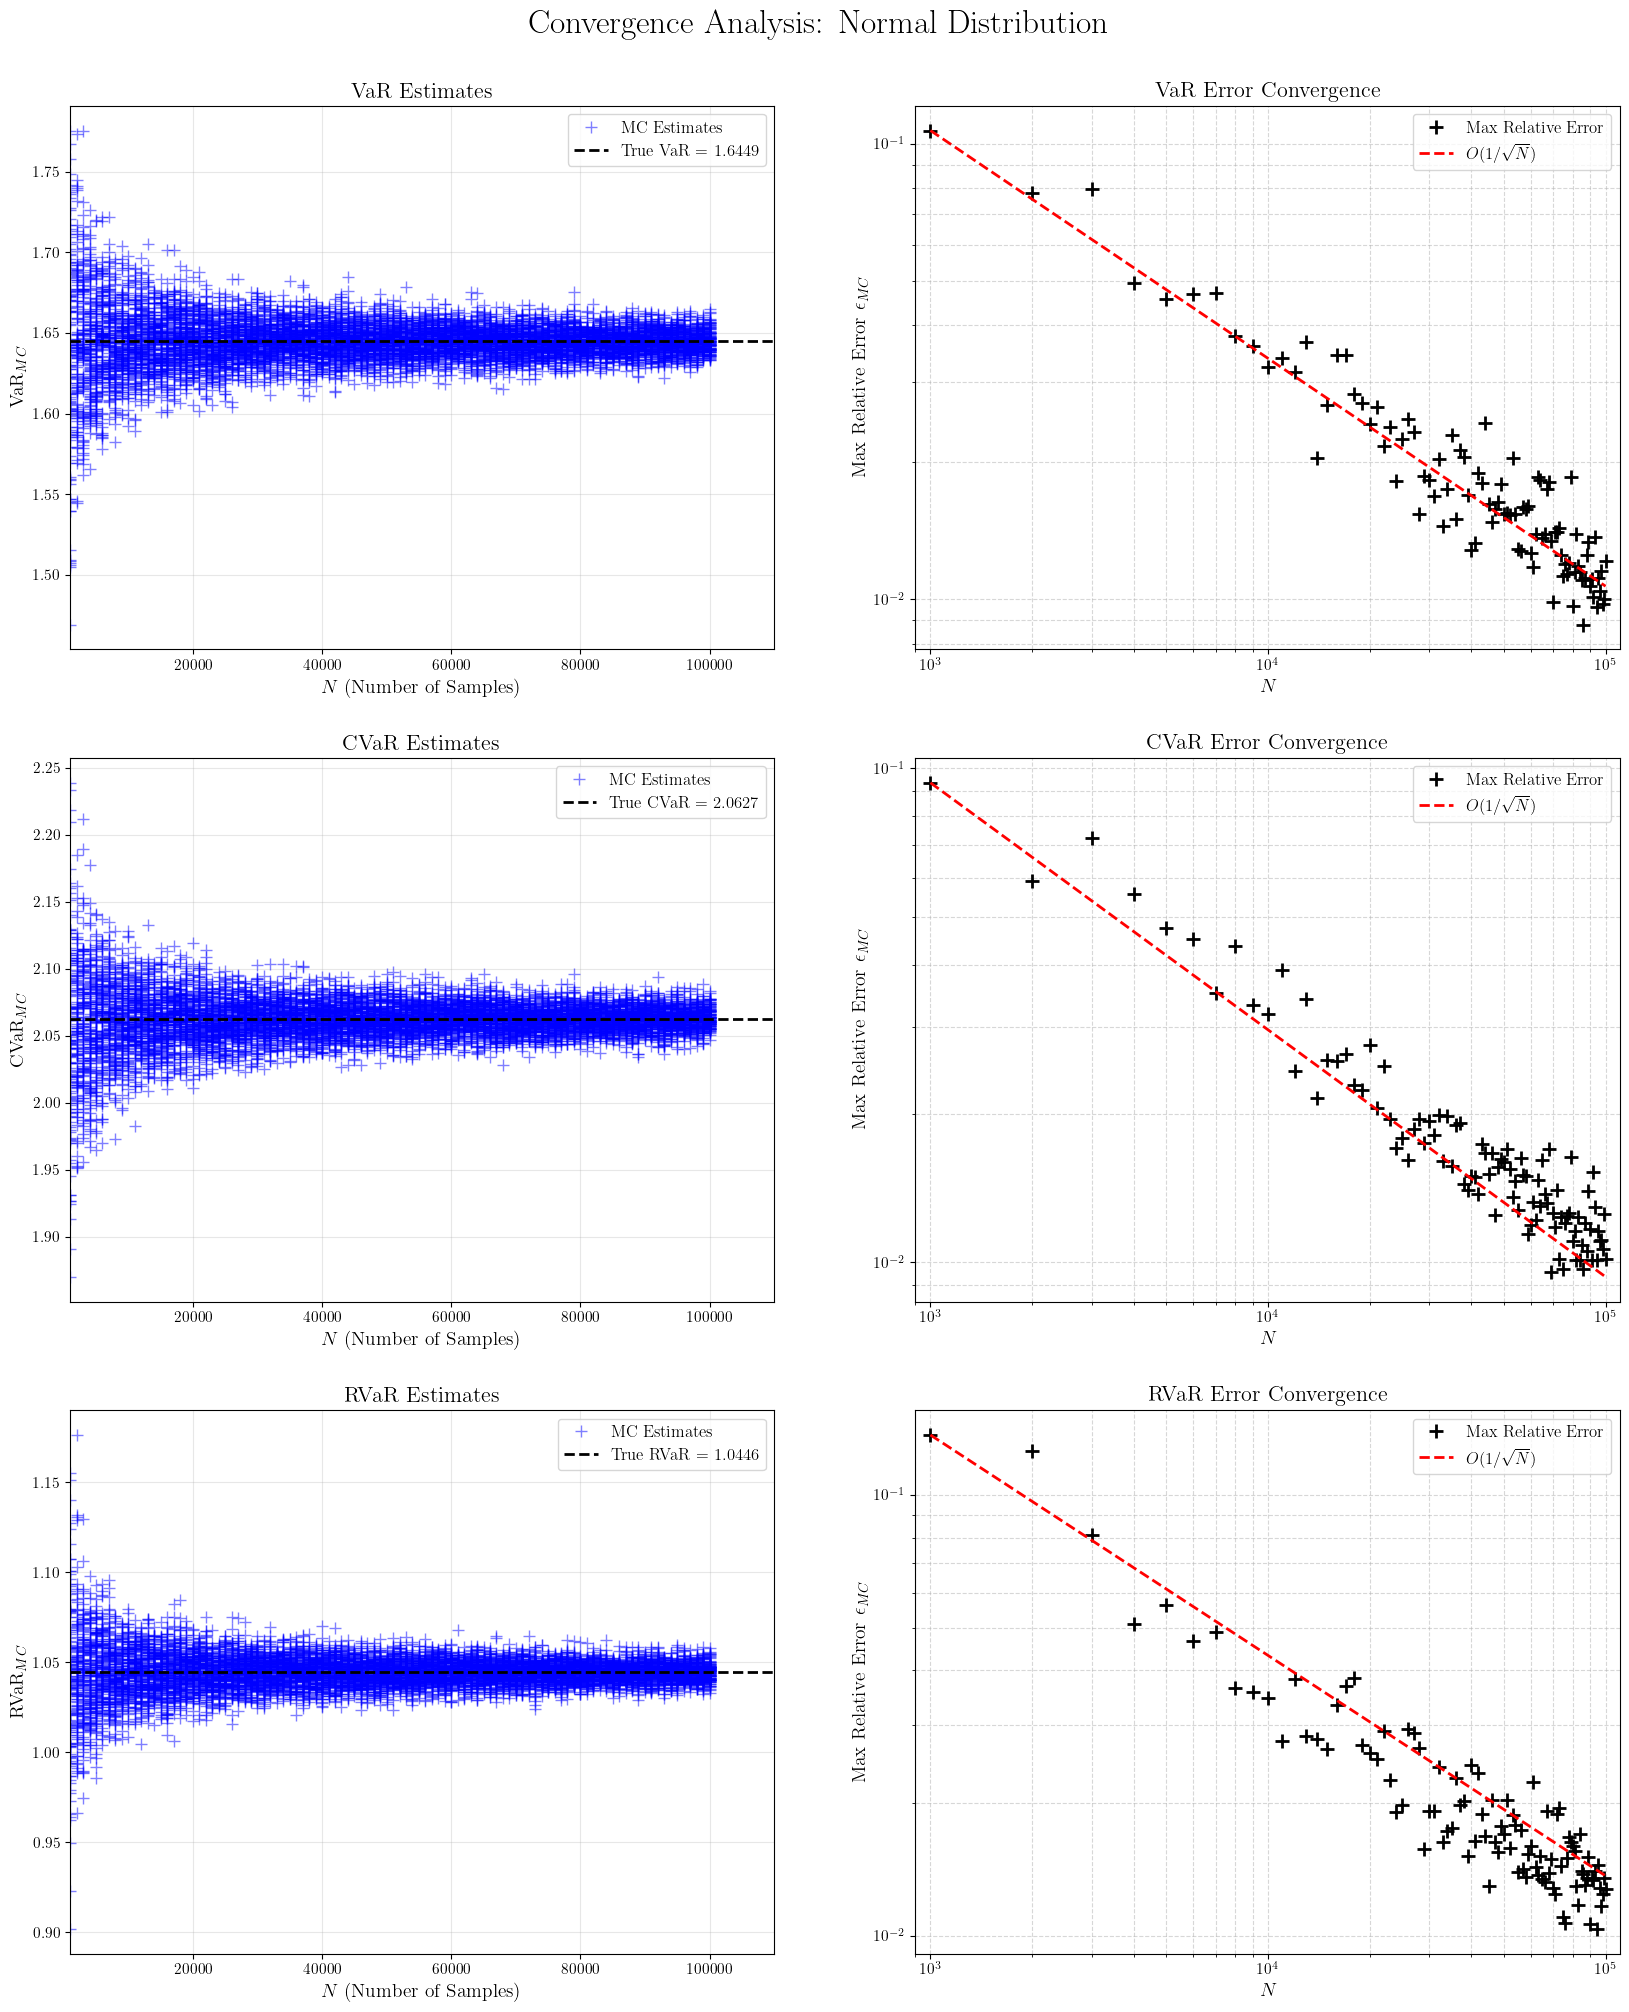

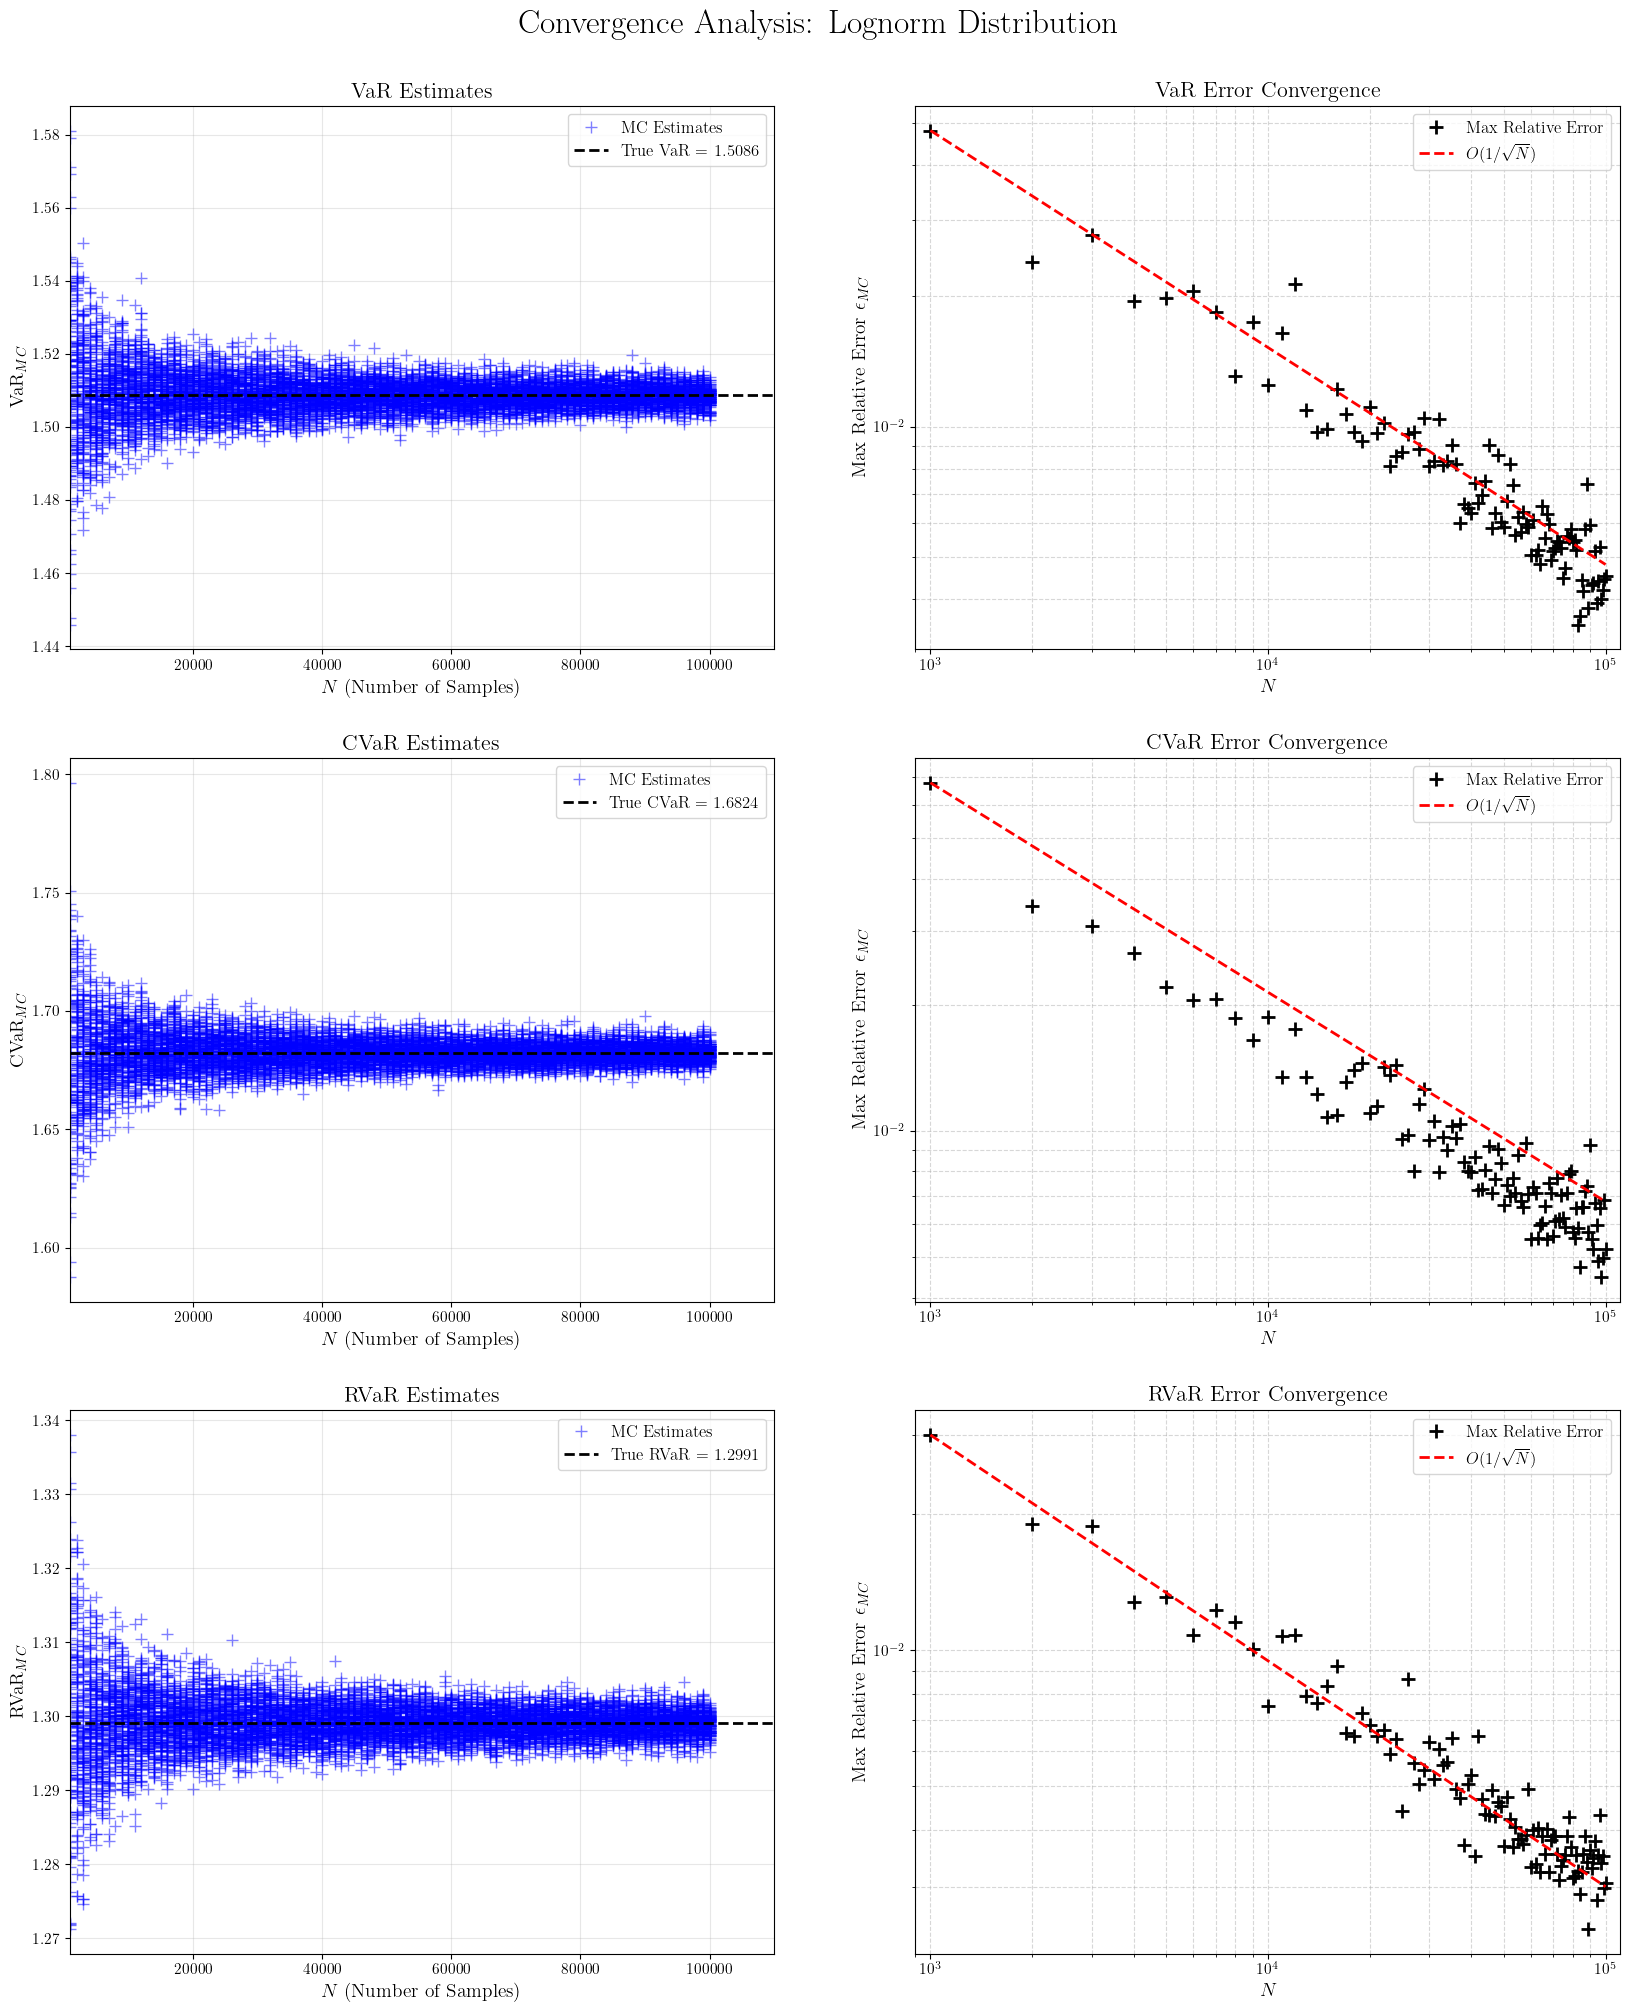

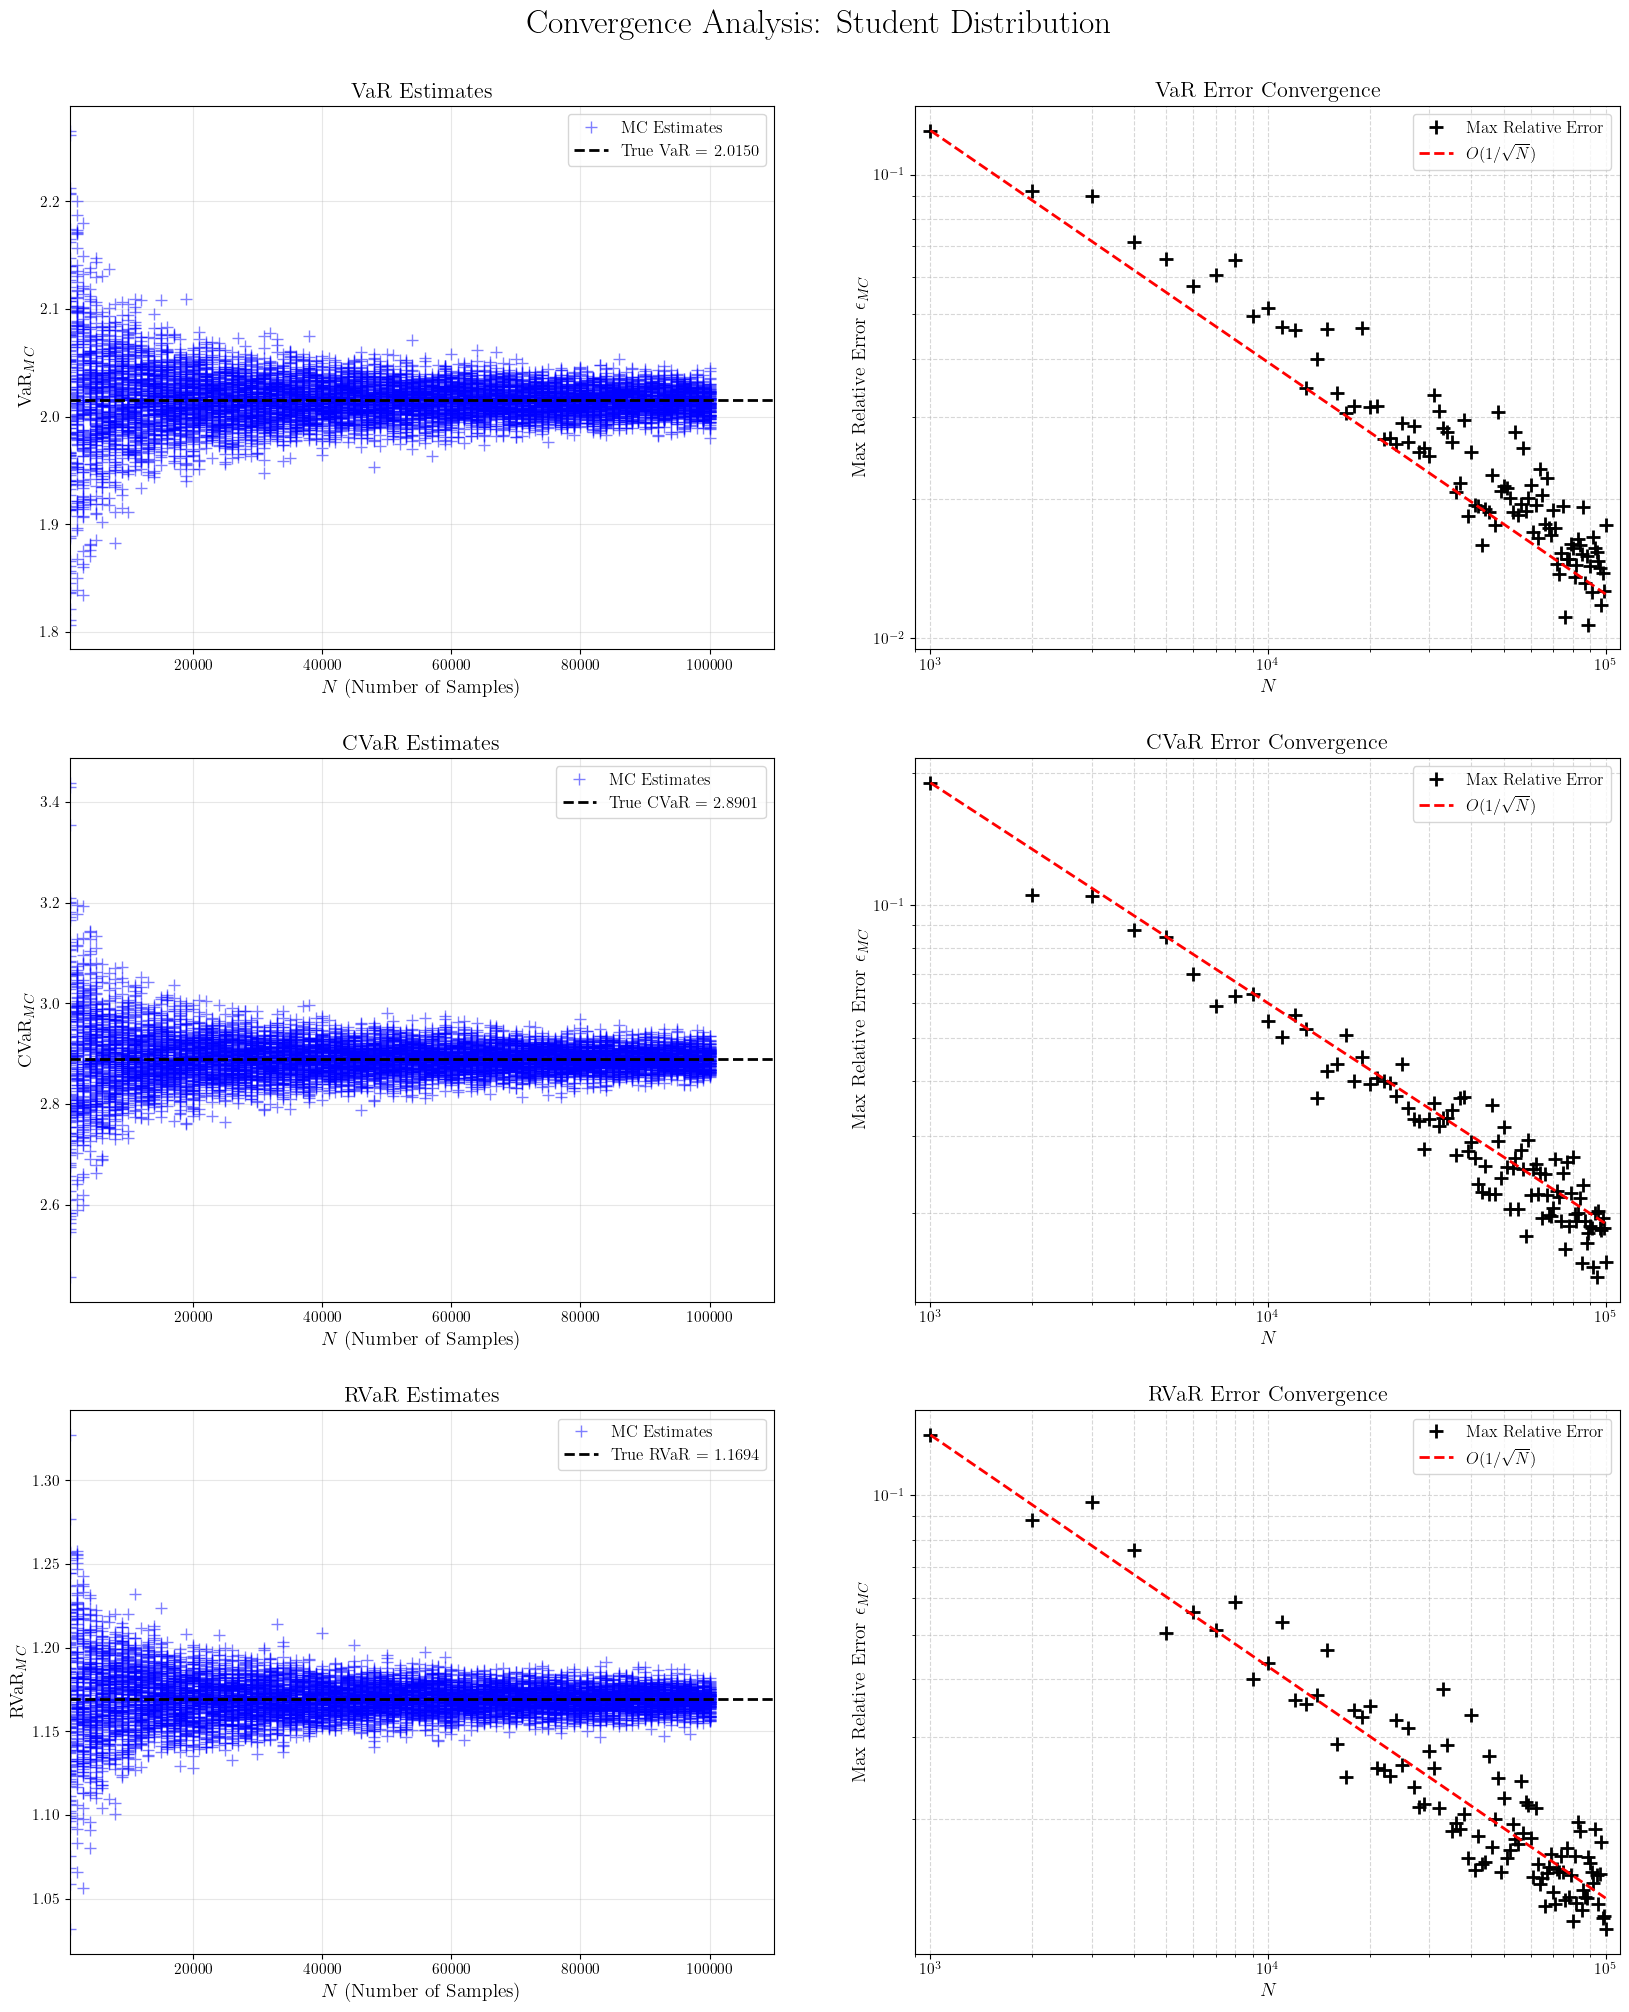

In [143]:
for dist, params in distributions.items():
    # 1. Get True Values
    var_true, cvar_true, rvar_true = get_analytical_values(dist, params)
    analytical_dict = {'VaR': var_true, 'CVaR': cvar_true, 'RVaR': rvar_true}
    
    # 2. Run Simulation
    df_results = run_mc_study(dist, params, n_samples, reps)
    
    # 3. Plot all measures (VaR, CVaR, RVaR)
    # We create a large figure with 3 rows (one for each measure)
    fig, axes = plt.subplots(3, 2, figsize=(20, 24))
    fig.suptitle(f"Convergence Analysis: {dist.capitalize()} Distribution", fontsize=24, y=0.92)
    
    plot_convergence(df_results, var_true, 'VaR', dist, axes=axes[0])
    plot_convergence(df_results, cvar_true, 'CVaR', dist, axes=axes[1])
    plot_convergence(df_results, rvar_true, 'RVaR', dist, axes=axes[2])
    
    plt.show()

# Quantum Risk Estimation 

In [144]:
from classiq import *
from classiq.applications.iqae.iqae import IQAE

## State Preparation

The objective of the state preparation step is to encode a probability distribution over a set of loss values into a quantum state. Specifically, we aim to prepare the state
\begin{equation}
    |\psi\rangle = \sum_i \sqrt{p_i}\,|X_i\rangle,
\end{equation}
where each basis state $|X_i\rangle$ is associated with a discrete loss value $X_i$, and $p_i$ denotes the probability assigned to that loss.

Each state $|X_i\rangle$ is represented in the computational basis using a binary encoding over $n_{\text{qubits}}$ qubits. For example,
\begin{align*}
    |X_0\rangle &\equiv |000\ldots 0\rangle, \\
    |X_1\rangle &\equiv |100\ldots 0\rangle, \\
    |X_3\rangle &\equiv |110\ldots 0\rangle.
\end{align*}

Using $n_{\text{qubits}}$ qubits, this encoding enables the representation of up to $2^{n_{\text{qubits}}}$ distinct loss values, each mapped to a unique computational basis state. In practice, the underlying loss distribution is continuous or defined over a large domain, and must therefore be truncated and discretized in order to obtain the finite set of loss values $\{X_i\}$ and their corresponding probabilities $\{p_i\}$. This discretization introduces an approximation whose accuracy depends on the resolution and range of the chosen encoding.



### Truncation and Discretization

Truncating and discretizing the loss distribution inevitably introduce approximation errors. As will be discussed later, these approximations lead to a bias in the resulting quantum estimator when compared to the underlying continuous distribution. 

In this section, we examine truncation and discretization procedures for the loss models introduced previously. The truncation step consists of restricting the loss domain to a finite interval $[x_{\min}, x_{\max}]$, while discretization is performed by partitioning this interval into bins of fixed width, which define the resolution of the encoding.






In [145]:
n_qubits = 10

def convert_n_bins(n_qubits: int) -> int:
    return 2**n_qubits

n_bins = convert_n_bins(n_qubits)
print(n_bins)

1024


For a Normal random variable $X \sim \mathcal{N}(\mu,\sigma^2)$, we define a truncated range using a $4\sigma$ interval around the mean:

\begin{equation*}
    x_{\min} = \mu - 4\sigma
\end{equation*}

\begin{equation*}
    x_{\max} = \mu + 4\sigma
\end{equation*}

This interval captures almost all of the probability mass of the Normal distribution while keeping a finite support for numerical integration and discretization.

The interval $[x_{\min}, x_{\max}]$ is then discretized using an evenly spaced grid.


In [146]:
k = 4.0  # number of standard deviations
x_min = normal_mu - k * normal_sigma
x_max = normal_mu + k * normal_sigma

print(x_min, x_max)

# Evenly spaced
x_normal = np.linspace(x_min, x_max, n_bins+1)
# Note that the + 1 factor accounts for the relationship between points and bins 
# (the usual "fence posts and rails" analogy).


-4.0 4.0


For $\ln X \sim \mathcal{N}(\mu,\sigma^2)$, we define a truncated range by applying a $4\sigma$ interval in log-space and mapping it back to the original domain:

\begin{equation*}
    x_{\min} = \exp(\mu - 4\sigma)
\end{equation*}

\begin{equation*}
    x_{\max} = \exp(\mu + 4\sigma)
\end{equation*}

This range captures almost all of the probability mass of the Lognormal distribution while respecting the positivity constraint $X > 0$ and keeping a finite support for numerical integration and discretization.

The interval $[x_{\min}, x_{\max}]$ is then discretized using an evenly spaced grid.


In [147]:
k = 4.0  # number of standard deviations in log-space
x_min = np.exp(lognorm_mu - k * lognorm_sigma)
x_max = np.exp(lognorm_mu + k * lognorm_sigma)

# Evenly spaced
x_lognormal = np.linspace(x_min, x_max, n_bins+1)

For a Student-t random variable $X \sim t_\nu(\mu,\sigma)$ with $\nu$ degrees of freedom, we define a truncated range in the same way as for the Normal distribution, independently of the value of $\nu$.

This choice is important in practice: using a truncation that is too close to the Normal case may fail to properly capture the heavier tails of the Student-t distribution. In financial applications, this can lead to an underestimation of extreme events such as crashes or large losses.

The interval $[x_{\min}, x_{\max}]$ is then discretized using an evenly spaced grid.


In [148]:
k = 4.0  # number of standard deviations
x_min = student_loc - k * student_scale
x_max = student_loc + k * student_scale

# Evenly spaced
x_student = np.linspace(x_min, x_max, n_bins+1)

### Construction of the discrete probability distribution

Once the truncated interval $[x_{\min}, x_{\max}]$ has been defined, it is discretized into $N$ subintervals.  
Let $\{x_i\}_{i=0}^{N+1}$ denote the grid points and let $\Delta x_i = x_{i+1} - x_i$ be the associated step size.

To define the discrete probability distribution $p = (p_0, \dots, p_{N})$, we use the midpoint rule.  
For each bin, the probability mass is approximated by evaluating the probability density function at the midpoint
\begin{equation*}
    \tilde{x}_i = \frac{x_i + x_{i+1}}{2},
\end{equation*}
and multiplying by the bin width:
\begin{equation*}
    p_i \approx f(\tilde{x}_i)\,\Delta x_i.
\end{equation*}

This approximation satisfies
\begin{equation*}
    \sum_{i=0}^{N} p_i \approx 1,
\end{equation*}
up to numerical truncation and discretization errors.

When the grid is not evenly spaced (for example, when using a logarithmic grid for a lognormal distribution), the step size $\Delta x_i$ is no longer constant and must be computed individually for each bin.  

In [149]:
x_normal_mid = 0.5 * (x_normal[:-1] + x_normal[1:])
dx = x_normal[1] - x_normal[0]
p_normal = norm.pdf(x_normal_mid, loc=normal_mu, scale=normal_sigma) * dx
print(len(p_normal)) 

# Safeguard: Normalize to ensure sum to 1
p_normal /= p_normal.sum()

1024


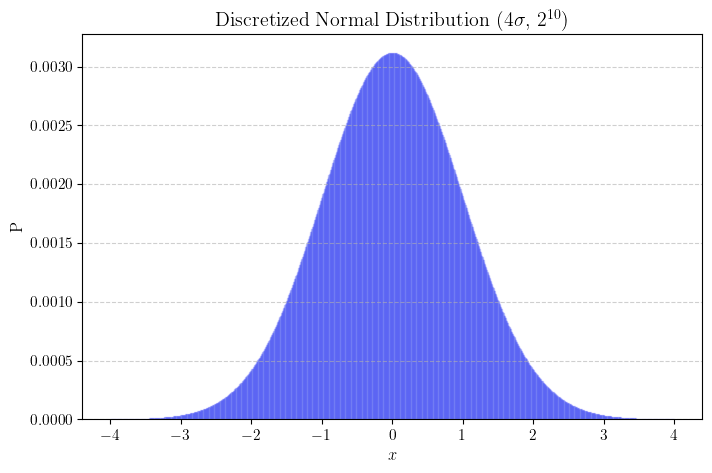

In [150]:
plt.figure(figsize=(8, 5))
plt.bar(x_normal_mid, p_normal, width=dx, alpha=0.2, edgecolor='blue', label="Discretized Bins")
plt.xlabel(r"$x$")
plt.ylabel(r"P")
plt.title(r"Discretized Normal Distribution ($4\sigma$, $2^{10}$)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [151]:
x_lognormal_mid = 0.5 * (x_lognormal[:-1] + x_lognormal[1:])
dx_lognormal = x_lognormal[1] - x_lognormal[0]
p_lognormal = lognorm.pdf(x_lognormal_mid, s=lognorm_sigma, scale=np.exp(lognorm_mu)) * dx_lognormal

p_lognormal /= p_lognormal.sum()


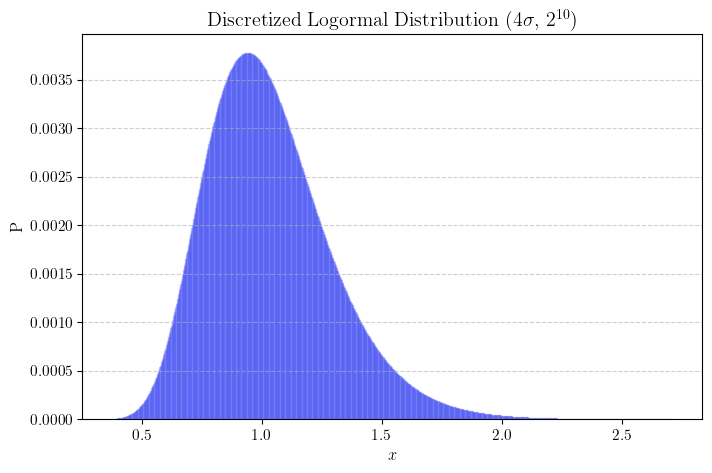

In [152]:
plt.figure(figsize=(8, 5))
plt.bar(x_lognormal_mid, p_lognormal, width=dx_lognormal, alpha=0.2, edgecolor='blue', label="Discretized Bins")
plt.xlabel(r"$x$")
plt.ylabel(r"P")
plt.title(r"Discretized Logormal Distribution ($4\sigma$, $2^{10}$)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

In [153]:
x_student_mid = 0.5 * (x_student[:-1] + x_student[1:])
dx_student = x_student[1] - x_student[0]
p_student = t.pdf(x_student_mid, df=student_df, loc=student_loc, scale=student_scale) * dx_student

# Safeguard: Normalize to ensure sum to 1
p_student/= p_student.sum()

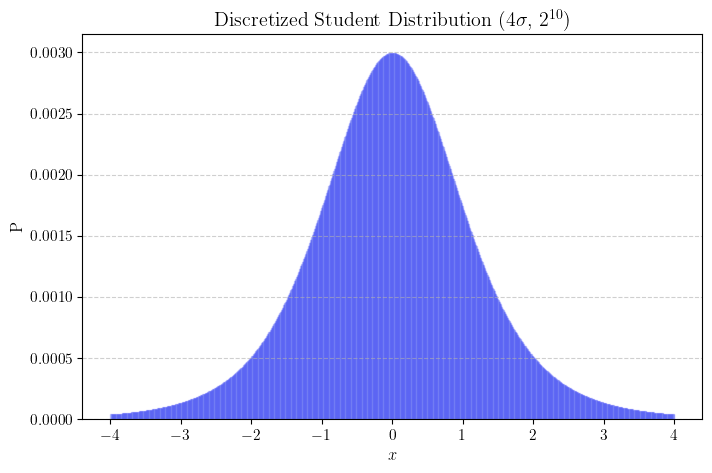

In [154]:
plt.figure(figsize=(8, 5))
plt.bar(x_student_mid, p_student, width=dx_student, alpha=0.2, edgecolor='blue')
plt.xlabel(r"$x$")
plt.ylabel(r"P")
plt.title(r"Discretized Student Distribution ($4\sigma$, $2^{10}$)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.show()

### Classiq Distribution Loading

In [155]:
@qfunc
def load_normal_distribution(asset: QNum):
    inplace_prepare_state(p_normal, bound=0, target=asset)

@qfunc
def load_lognormal_distribution(asset: QNum):
    inplace_prepare_state(p_lognormal, bound=0, target=asset)

@qfunc
def load_student_distribution(asset: QNum):
    inplace_prepare_state(p_student, bound=0, target=asset) 

## Payoff Functions

Now that we have prepared the state $\sum_{i=0}^{N-1} \sqrt{p_i}\, |i\rangle |0\rangle$, it is time to implement the payoff functions.

A payoff function takes the general form $f : \{0,\dots,N-1\} \to [0,1]$ and is encoded through a controlled rotation on an ancilla qubit:
\begin{equation*}
|i\rangle |0\rangle
\;\mapsto\;
|i\rangle
\left(
\sqrt{1 - f(i)}\,|0\rangle
+
\sqrt{f(i)}\,|1\rangle
\right).
\end{equation*}

Applying this map to the full superposition yields
\begin{equation*}
\sum_{i=0}^{N-1} \sqrt{p_i}\, |i\rangle |0\rangle
\;\mapsto\;
\sum_{i=0}^{N-1} \sqrt{p_i}\, |i\rangle
\left(
\sqrt{1 - f(i)}\,|0\rangle
+
\sqrt{f(i)}\,|1\rangle
\right).
\end{equation*}

The probability of measuring the ancilla in state $|1\rangle$ is then,

\begin{equation*}
\mathbb{P}(1)
=
\sum_{i=0}^{N-1} p_i f(i)
=
\mathbb{E}[f(X)].
\end{equation*}




In the article [Quantum Risk Analysis](https://arxiv.org/pdf/1806.06893.pdf), 
the payoff functions are chosen so that Quantum Amplitude Estimation returns the quantities needed to recover $\mathrm{VaR}$ and $\mathrm{CVaR}$.

### VaR Payoff

For a confidence level $\alpha\in(0,1)$, define the index-threshold payoff (a step function)

\begin{equation*}
f_l(i)=
\begin{cases}
1, & i \le l,\\
0, & i > l.
\end{cases}
\end{equation*}

Then amplitude estimation returns
\begin{equation*}
\mathbb{E}[f_l(X)] = \sum_{i=0}^{N-1} p_i f_l(i) = \sum_{i=0}^{l} p_i = \mathbb{P}(X \le x_l).
\end{equation*}
The VaR index $l_\alpha$ is the smallest $l$ such that
\begin{equation*}
\mathbb{P}(X \le x_l) \ge \alpha,
\end{equation*}
and the corresponding risk measure is
\begin{equation*}
\mathrm{VaR}_\alpha(X)=x_{l_\alpha}.
\end{equation*}
Operationally, the paper proposes to find $l_\alpha$ via a classical bisection search over $l$, where each step evaluates $\mathbb{P}(X\le x_l)$ using amplitude estimation.

### CVaR Payoff

Once the VaR index $l_\alpha$ is known, CVaR is estimated by using

\begin{equation*}
f^{\mathrm{CVaR}}_l(i)=
\begin{cases}
i/l, & i \le l,\\
0, & i > l,
\end{cases}
\end{equation*}

which ensures $f^{\mathrm{CVaR}}_l(i)\in[0,1]$. <br>
Amplitude estimation yields

\begin{equation*}
\mathbb{E}\!\left[f^{\mathrm{CVaR}}_l(X)\right]
=
\sum_{i=0}^{l} p_i \frac{i}{l}
=
\frac{1}{l}\sum_{i=0}^{l} i\,p_i.
\end{equation*}

and the CVaR is found back using

\begin{equation*}
\mathrm{CVaR}_\alpha(X)
=
x_0 + \Delta \,\frac{l_\alpha\,\mathbb{E}\!\left[f^{\mathrm{CVaR}}_{l_\alpha}(X)\right]}{P_{l_\alpha}}.
\end{equation*}

where ... If the grid is uniform with spacing $\Delta$ and origin shift $x_i = x_0 + i\Delta$, then

In practice, this is implemented by estimating both $P_{l_\alpha}$ (using $f_{l_\alpha}$) and $\mathbb{E}[f^{\mathrm{CVaR}}_{l_\alpha}(X)]$ (using $f^{\mathrm{CVaR}}_{l_\alpha}$) with amplitude estimation, and then combining them classically.


### RVaR Payoff

To estimate $\mathrm{RVaR}_{\alpha, \beta}$ for a probability range defined by confidence levels $\alpha < \beta$, we first identify two indices $l_\alpha$ and $l_\beta$ (using the search method described for VaR) such that $\mathbb{P}(X \le x_{l_\alpha}) \approx \alpha$ and $\mathbb{P}(X \le x_{l_\beta}) \approx \beta$.

The payoff function is chosen to isolate the contribution of asset values falling strictly between these two thresholds:

\begin{equation*}
f^{\mathrm{RVaR}}_{l_\alpha, l_\beta}(i)=
\begin{cases}
i/l_\beta, & l_\alpha < i \le l_\beta,\\
0, & \text{otherwise},
\end{cases}
\end{equation*}

where the normalization by $l_\beta$ ensures the values remain in $[0,1]$.
Amplitude estimation yields

\begin{equation*}
\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_\alpha, l_\beta}(X)\right]
=
\sum_{i=l_\alpha+1}^{l_\beta} p_i \frac{i}{l_\beta}
=
\frac{1}{l_\beta}\sum_{i=l_\alpha+1}^{l_\beta} i\,p_i.
\end{equation*}

The RVaR is recovered by normalizing this sum by the probability mass contained within the interval, denoted as $P_{l_\alpha, l_\beta} = \sum_{i=l_\alpha+1}^{l_\beta} p_i$:

\begin{equation*}
\mathrm{RVaR}_{\alpha, \beta}(X)
=
x_0 + \Delta \,\frac{l_\beta\,\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_\alpha, l_\beta}(X)\right]}{P_{l_\alpha, l_\beta}}.
\end{equation*}

In practice, this requires estimating $P_{l_\alpha, l_\beta}$ (using a window indicator function where $f(i) = 1$ if $l_\alpha < i \le l_\beta$, else $0$) and $\mathbb{E}[f^{\mathrm{RVaR}}_{l_\alpha, l_\beta}(X)]$ separately via amplitude estimation, and then combining the results classically.




## Complete IQAE Process for VaR

To compute the Value at Risk ($\text{VaR}_\alpha$) using IQAE, we rely on the hybrid quantum-classical approach described earlier.

---

Algorithm 1: `VaR_iqae_bisection_search`
1.  Initialize: Define the search range $[l_{\min}, l_{\max}]$ for the asset distribution.
2.  Iterate (Bisection Search):
    * Select a candidate threshold $l_{mid} = \frac{l_{\min} + l_{\max}}{2}$.
    * State Preparation:
        * Distribution Loading.
        * VaR Payoff.
    * Estimation: Run IQAE to estimate the probability $p = \mathbb{P}(X \le x_{mid})$.
    * Update:
        * If $p < \alpha$, the threshold is too low (move to upper half).
        * If $p \ge \alpha$, the threshold is high enough (move to lower half).
3.  Converge: Repeat until the interval is within the desired precision. The final $x_{mid}$ is the estimated $\text{VaR}_\alpha$.

---


In [157]:
written_qmod = False

def get_initial_index(n_qubits):
    return int(2**n_qubits) // 4

def estimate_cdf_iqae_at_index(
    n_qubits: int,
    probability_distribution: str,
    l: int,
    epsilon: float = 0.05,
) -> float:
    """
    Returns p(l) = P(X <= x_l) using IQAE, where l is a DISCRETE index in {0,...,2^n-1}.
    This resynthesizes the circuit each time l changes (simple + correct).
    """

    @qperm
    def payoff(asset: Const[QNum], ind: QBit):
        ind ^= asset <= l

    @qfunc(synthesize_separately=True)
    def state_preparation(asset: QArray[QBit], ind: QBit):
        if probability_distribution == "normal":
            load_normal_distribution(asset=asset)
        elif probability_distribution == "lognormal":
            load_lognormal_distribution(asset=asset)
        elif probability_distribution == "student":
            load_student_distribution(asset=asset)
        else:
            raise ValueError("Unsupported distribution type.")
        payoff(asset=asset, ind=ind)

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=n_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=n_qubits),
    )

    res = iqae.run(epsilon=epsilon, alpha=0.01)
    return res.estimation


def VaR_IQAE(
    n_qubits: int,
    probability_distribution: str,
    target_alpha: float = 0.95,
    epsilon: float = 0.05,
) -> float:
    """
    Returns VaR value x_{l_alpha} where l_alpha is the smallest index with P(X <= x_l) >= target_alpha.
    """

    # pick the grid that matches how you loaded the distribution
    if probability_distribution == "normal":
        grid_points = x_normal_mid
    elif probability_distribution == "lognormal":
        grid_points = x_lognormal_mid
    elif probability_distribution == "student":
        grid_points = x_student_mid
    else:
        raise ValueError("Unsupported distribution type.")

    N = 2 ** n_qubits
    if len(grid_points) != N:
        raise ValueError(f"grid_points has length {len(grid_points)} but expected {N} (=2**n_qubits)")

    lo, hi = 0, N - 1
    while lo < hi:
        mid = (lo + hi) // 2
        p_mid = estimate_cdf_iqae_at_index(
            n_qubits,
            probability_distribution,
            l=mid,
            epsilon=epsilon,
        )

        if p_mid < target_alpha:
            lo = mid + 1
        else:
            hi = mid

    return grid_points[lo]

In [ ]:
var_normal = VaR_IQAE(n_qubits=10, probability_distribution='normal', target_alpha=0.95)
print(var_normal)

## Complete IQAE Process for CVaR


Computing the CVaR using IQAE is a two step process where the first step consists in computing the VaR, $l_\alpha$, using the former `VaR_iqae_bisection_search`. <br>
The second step consists in estimating $\mathbb{E}\!\left[f^{\mathrm{CVaR}}_{l_\alpha}(X)\right]$ and $P_{l_\alpha}$ in order to compute

\begin{equation*}
\mathrm{CVaR}_\alpha(X)
=
x_0 + \Delta \,\frac{l_\alpha\,\mathbb{E}\!\left[f^{\mathrm{CVaR}}_{l_\alpha}(X)\right]}{P_{l_\alpha}}.
\end{equation*}

This is done again using IQAE.

---

Algorithm 2: `CVaR_IQAE`


0. (Run `VaR_iqae_bisection_search` to obtain $l_\alpha$)

1. First Estimation: Use the same step payoff $f_{l_\alpha}$, run IQAE to estimate $P_{l_\alpha} = \sum_{i=0}^{l_\alpha} p_i$.
    
2. Second Estimation: Use the CVaR payoff $f^{\mathrm{CVaR}}_{l}(i)$ to estimate $\mathbb{E}\!\left[f^{\mathrm{CVaR}}_{l_\alpha}(X)\right]$

3. Recover CVaR

---


In [161]:
from classiq import qfunc, QNum, QBit, Const, control
from classiq.qmod.symbolic import ceiling
from classiq import lookup_table

def CVaR_IQAE(
    n_qubits: int,
    probability_distribution: str,
    VaR: float = None,
    epsilon: float = 0.05,
    target_alpha: float = 0.95,
    tol: float = 1e-3,
) -> float:
    if VaR is None:
        VaR = compute_var_iqae(
            n_qubits,
            probability_distribution,
            epsilon=epsilon,
            target_alpha=target_alpha,
            tol=tol,
        )

    global GLOBAL_INDEX  # used by your `payoff(asset, ind): ind ^= asset < GLOBAL_INDEX`
    if probability_distribution == 'normal':
        grid_points = x_normal_mid
        load_distribution = load_normal_distribution
    elif probability_distribution == 'lognormal':
        grid_points = x_lognormal_mid
        load_distribution = load_lognormal_distribution
    elif probability_distribution == 'student':
        grid_points = x_student_mid
        load_distribution = load_student_distribution

    # Map qubit-label space <-> value space (same mapping pattern as Classiq docs)
    grid_step = (max(grid_points) - min(grid_points)) / (len(grid_points) - 1)

    def scale(label: int) -> float:
        return label * grid_step + min(grid_points)

    def descale(val: float) -> float:
        return (val - min(grid_points)) / grid_step

    # VaR label (index) on the discretized grid
    l_idx = int(np.clip(np.floor(descale(VaR)), 0, 2**n_qubits - 1))

    @qperm
    def payoff(asset: Const[QNum], ind: QBit):
        ind ^= asset < GLOBAL_INDEX

    @qfunc
    def state_preparation(asset: QArray[QBit], ind: QBit):
        load_distribution(asset=asset)
        payoff(asset=asset, ind=ind)
        

    def estimate_cdf_lt(k: int) -> float:
        # estimates P(asset < k) with your existing state_preparation/payoff
        global GLOBAL_INDEX
        GLOBAL_INDEX = int(k)

        iqae = IQAE(
            state_prep_op=state_preparation,        # <- defined in your notebook
            problem_vars_size=n_qubits,
            constraints=Constraints(max_width=28),
            preferences=Preferences(machine_precision=n_qubits),
        )
        res = iqae.run(epsilon=epsilon, alpha=0.01)
        return float(res.estimation)

    F_l = estimate_cdf_lt(l_idx + 1)   # P(X <= VaR)
    F_lm1 = estimate_cdf_lt(l_idx)     # P(X <= VaR - one grid step)
    p_l = max(0.0, F_l - F_lm1)

    if p_l < 1e-12:
        f_l_alpha = 0.0
    else:
        f_l_alpha = (F_l - target_alpha) / p_l
        f_l_alpha = float(np.clip(f_l_alpha, 0.0, 1.0))

    scaling_factor = max(grid_points)  # ensures (scale(n)/scaling_factor) in [0,1]

    @qfunc
    def payoff_tail(asset: Const[QNum], ind: QBit):
        # apply amplitude loading only when X > VaR
        control(asset > ceiling(descale(VaR)), lambda: payoff_tail_linear(asset, ind))

    @qfunc
    def payoff_tail_linear(asset: Const[QNum], ind: QBit):
        # load sqrt( scale(asset) / scaling_factor ) into |1> amplitude
        assign_amplitude_table(
            lookup_table(lambda n: np.sqrt(abs(scale(n) / scaling_factor)), asset),
            asset,
            ind,
        )

    @qfunc
    def cvar_state_preparation(asset: QNum, ind: QBit):
        load_distribution(asset)  # <- defined in your notebook
        payoff_tail(asset, ind)

    iqae_tail = IQAE(
        state_prep_op=cvar_state_preparation,
        problem_vars_size=n_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=n_qubits),
    )
    res_tail = iqae_tail.run(epsilon=epsilon, alpha=0.01)

    E_tail_strict = float(res_tail.estimation) * scaling_factor  # E[X * 1_{X > VaR}]

    cvar_num = E_tail_strict + f_l_alpha * float(VaR) * p_l
    cvar = cvar_num / max(1e-12, (1.0 - target_alpha))

    return float(cvar)


In [162]:
cvar_nornal = CVaR_IQAE(n_qubits=10, probability_distribution='normal', VaR=var_normal, target_alpha=0.95, tol=1e-3)
print(cvar_nornal)

1.9605246820845135


## Complete IQAE Process for RVaR

Computing the RVaR using IQAE is a two step process where the first step consists in computing the two VaR thresholds, $l_{\alpha_1}$ and $l_{\alpha_2}$, using `VaR_iqae_bisection_search` (run twice). <br>
The second step consists in estimating the slice probability $P_{l_{\alpha_1},l_{\alpha_2}}$ and the slice-payoff expectation $\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_{\alpha_1},l_{\alpha_2}}(X)\right]$ in order to compute

\begin{equation*}
\mathrm{RVaR}_{\alpha_1,\alpha_2}(X)
=
x_0 + \Delta\left(
l_{\alpha_1}
+
(l_{\alpha_2}-l_{\alpha_1})\,
\frac{\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_{\alpha_1},l_{\alpha_2}}(X)\right]}{P_{l_{\alpha_1},l_{\alpha_2}}}
\right).
\end{equation*}

This is done again using IQAE.

---

Algorithm 3: `RVaR_IQAE`

0. (Run `VaR_iqae_bisection_search` at $\alpha_1$ and $\alpha_2$ to obtain $l_{\alpha_1}$ and $l_{\alpha_2}$ respectively)

1. First Estimation: Use the step payoff $f_{l}(i)=\mathbf{1}\{i\le l\}$ and IQAE to estimate  
\begin{equation*}
P_{l_{\alpha_1}}=\sum_{i=0}^{l_{\alpha_1}}p_i
\qquad\text{and}\qquad
P_{l_{\alpha_2}}=\sum_{i=0}^{l_{\alpha_2}}p_i.
\end{equation*}

2. Slice Probability: Compute  
\begin{equation*}
P_{l_{\alpha_1},l_{\alpha_2}} = P(\,l_{\alpha_1}<X\le l_{\alpha_2}\,) = P_{l_{\alpha_2}}-P_{l_{\alpha_1}}.
\end{equation*}

3. Second Estimation: Use the RVaR payoff
\begin{equation*}
f^{\mathrm{RVaR}}_{l_{\alpha_1},l_{\alpha_2}}(i)
=
\frac{i-l_{\alpha_1}}{l_{\alpha_2}-l_{\alpha_1}}\,
\mathbf{1}\{l_{\alpha_1}< i\le l_{\alpha_2}\},
\end{equation*}
and run IQAE to estimate $\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_{\alpha_1},l_{\alpha_2}}(X)\right]$.

4. Recover RVaR (with $x=x_0+\Delta i$):

\begin{equation*}
\mathrm{RVaR}_{\alpha_1,\alpha_2}(X)
=
x_0 + \Delta\left(
l_{\alpha_1}
+
(l_{\alpha_2}-l_{\alpha_1})\,
\frac{\mathbb{E}\!\left[f^{\mathrm{RVaR}}_{l_{\alpha_1},l_{\alpha_2}}(X)\right]}{P_{l_{\alpha_1},l_{\alpha_2}}}
\right).
\end{equation*}

---


In [173]:
# Globals used inside qfunc conditions / payoff
GLOBAL_L1 = 0
GLOBAL_L2 = 0
GLOBAL_DEN = 1

@qfunc
def payoff_rvar_slice(asset: Const[QNum], ind: QBit):
    # Apply the amplitude loading only when l1 < asset <= l2
    control(asset > GLOBAL_L1, lambda:
        control(asset <= GLOBAL_L2, lambda:
            payoff_rvar_slice_linear(asset, ind)
        )
    )

@qfunc
def payoff_rvar_slice_linear(asset: Const[QNum], ind: QBit):
    # Safe: table is valid for all n
    assign_amplitude_table(
        lookup_table(
            lambda n: (
                np.sqrt((n - GLOBAL_L1) / GLOBAL_DEN)
                if (n > GLOBAL_L1 and n <= GLOBAL_L2 and GLOBAL_DEN > 0)
                else 0.0
            ),
            asset,
        ),
        asset,
        ind,
    )

def RVaR_IQAE(
    n_qubits: int,
    probability_distribution: str,
    alpha1: float = 0.90,
    alpha2: float = 0.95,
    VaR1: float = None,
    VaR2: float = None,
    epsilon: float = 0.05,
) -> float:

    # 0) Get the two VaRs (values on the grid)
    if VaR1 is None:
        VaR1 = VaR_IQAE(n_qubits, probability_distribution, target_alpha=alpha1, epsilon=epsilon)
    if VaR2 is None:
        VaR2 = VaR_IQAE(n_qubits, probability_distribution, target_alpha=alpha2, epsilon=epsilon)

    # Pick the grid + loader
    if probability_distribution == "normal":
        grid_points = x_normal_mid
        load_distribution = load_normal_distribution
    elif probability_distribution == "lognormal":
        grid_points = x_lognormal_mid
        load_distribution = load_lognormal_distribution
    elif probability_distribution == "student":
        grid_points = x_student_mid
        load_distribution = load_student_distribution
    else:
        raise ValueError("Unsupported distribution type.")

    N = 2 ** n_qubits
    if len(grid_points) != N:
        raise ValueError(f"grid_points has length {len(grid_points)} but expected {N} (=2**n_qubits)")

    # Map value <-> label (uniform grid)
    grid_step = (max(grid_points) - min(grid_points)) / (len(grid_points) - 1)

    def descale(val: float) -> float:
        return (val - min(grid_points)) / grid_step

    # Labels (indices) for the VaR values
    l1 = int(np.clip(np.floor(descale(VaR1)), 0, N - 2))
    l2 = int(np.clip(np.floor(descale(VaR2)), l1 + 1, N - 1))

    # 1) Slice probability p_slice = P(l1 < X <= l2)
    F_l1 = float(estimate_cdf_iqae_at_index(n_qubits, probability_distribution, l=l1, epsilon=epsilon))
    F_l2 = float(estimate_cdf_iqae_at_index(n_qubits, probability_distribution, l=l2, epsilon=epsilon))
    p_slice = max(1e-12, F_l2 - F_l1)

    # 2) Estimate a = E[ ( (i-l1)/(l2-l1) ) * 1{l1 < i <= l2} ]
    global GLOBAL_L1, GLOBAL_L2, GLOBAL_DEN
    GLOBAL_L1 = int(l1)
    GLOBAL_L2 = int(l2)
    GLOBAL_DEN = int(l2 - l1)

    @qfunc
    def rvar_state_preparation(asset: QArray[QBit], ind: QBit):
        load_distribution(asset=asset)
        payoff_rvar_slice(asset=asset, ind=ind)

    iqae = IQAE(
        state_prep_op=rvar_state_preparation,
        problem_vars_size=n_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=n_qubits),
    )
    res = iqae.run(epsilon=epsilon, alpha=0.01)
    a_hat = float(res.estimation)

    # 3) Recover RVaR in value space
    rvar = float(VaR1 + (VaR2 - VaR1) * (a_hat / p_slice))
    return rvar

In [ ]:
rvar_normal = RVaR_IQAE(n_qubits=10, probability_distribution="normal", alpha1=0.90, alpha2=0.95, epsilon=0.02)
print(rvar_normal)